In [1]:
import json

with open("data/all_delisted_data.json") as f:
    delisted_data = json.load(f)

with open("data/all_formatted_pre_data.json") as f:
    all_data = json.load(f)

In [3]:
import pandas as pd

delist_feature_list = pd.DataFrame({})
all_feature_list = pd.DataFrame({})

In [4]:
feature_key_list = [
    "price_ave",
    "price_med",
    "price_dev",
    "price_min",
    "price_max",
    "price_max_change",
    "price_min_change",
    "price_sum_abs_change_rate",
    "price_short_dev",
    "price_range",
    "price_max_down",
    "price_max_mean",
    "volume_ave",
    "volume_med",
    "volume_dev",
    "volume_min",
    "volume_max",
    "volume_max_change",
    "volume_min_change",
    "volume_sum_abs_change_rate",
    "volume_short_dev",
    "volume_range",
    "volume_max_down",
    "volume_max_mean"] 

In [5]:
import statistics

def split_list(l, n):
    """
    リストをサブリストに分割する
    :param l: リスト
    :param n: サブリストの要素数
    :return: 
    """
    for idx in range(0, len(l), n):
        yield l[idx:idx + n]
 

def cul_feature(data):
    ave = statistics.mean(data)
    med = statistics.median(data)
    dev = statistics.pstdev(data)
    min_data = min(data)
    max_data = max(data)
    max_change = -(10 ** 10)
    min_change = 10 ** 10
    sum_change = 0
    div_data = list(split_list(data, 4))
    short_dev = 0
    data_range = max(data)-min(data)
    data_down_rate = (max(data) - min(data)) / (min(data) + 0.0000000000000000001)
    max_mean = max_data - ave
    for i in range(len(div_data)):
        short_dev += statistics.pstdev(div_data[i])
    short_dev = short_dev / len(div_data)
    for i in range(1,len(data)):
        temp_change = (data[i] - data[i-1]) / (data[i-1] + + 0.0000000000000000001)
        if max_change < temp_change:
            max_change = temp_change
        if min_change > temp_change:
            min_change = temp_change
        sum_change = abs(temp_change)
    
    feature_data = [ave, med, dev, min_data, max_data, max_change, min_change, sum_change, short_dev, data_range, data_down_rate, max_mean]
    return feature_data
        

In [6]:
for i, (key, value) in enumerate(delisted_data.items()):
    if value["price"] != []:
        price_feature = cul_feature(value["price"])
        volume_feature = cul_feature(value["volume"])
        add_data = price_feature + volume_feature
        add_dataframe = pd.Series(add_data, index=feature_key_list)
        delist_feature_list[key] = add_dataframe

for i, (key, value) in enumerate(all_data.items()):
    if value["price"] != []:
        price_feature = cul_feature(value["price"])
        volume_feature = cul_feature(value["volume"])
        add_data = price_feature + volume_feature
        add_dataframe = pd.Series(add_data, index=feature_key_list)
        all_feature_list[key] = add_dataframe

/var/folders/56/psj7ncmx4wg4kv9hzqkrrnmc0000gn/T/ipykernel_16073/3152356920.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_feature_list[key] = add_dataframe
/var/folders/56/psj7ncmx4wg4kv9hzqkrrnmc0000gn/T/ipykernel_16073/3152356920.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_feature_list[key] = add_dataframe
/var/folders/56/psj7ncmx4wg4kv9hzqkrrnmc0000gn/T/ipykernel_16073/3152356920.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

In [12]:
import numpy as np

def remove_outliers_index(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 30 * iqr
    upper_bound = q3 + 30 * iqr
    index_list = set()
    for i, value in enumerate(data):
        if value > upper_bound:
            index_list.add(i)    
    return index_list

In [13]:
format_all_feature = all_feature_list.T
format_delist_feature = delist_feature_list.T
join_feature = pd.concat([format_delist_feature, format_all_feature])

In [14]:
join_price_feature = join_feature.loc[:, ["price_ave", "price_med", "price_dev", "price_min", "price_max", "price_max_change", "price_min_change", "price_sum_abs_change_rate", "price_short_dev", "price_range", "price_max_down", "price_max_mean"]]
join_volume_feature = join_feature.loc[:, ["volume_ave", "volume_med", "volume_dev", "volume_min", "volume_max", "volume_max_change", "volume_min_change", "volume_sum_abs_change_rate", "volume_short_dev", "volume_range", "volume_max_down", "volume_max_mean"]]

In [15]:
price_out_index = set()
volume_out_index = set()

for i, (key, value) in enumerate(join_price_feature.items()):
    bad = remove_outliers_index(value)
    price_out_index = price_out_index | bad

for i, (key, value) in enumerate(join_volume_feature.items()):
    bad = remove_outliers_index(value)
    volume_out_index = volume_out_index | bad

In [16]:
format_join_price_feature = pd.DataFrame()
format_join_volume_feature = pd.DataFrame()


for i, (key, value) in enumerate(join_price_feature.items()):
    temp_series = pd.Series()
    for j, (keys, value) in enumerate(value.items()):
        if j not in price_out_index:
            temp_series[keys] = value
    format_join_price_feature[key] = temp_series

for i, (key, value) in enumerate(join_volume_feature.items()):
    temp_series = pd.Series()
    for j, (keys, value) in enumerate(value.items()):
        if j not in volume_out_index:
            temp_series[keys] = value
    format_join_volume_feature[key] = temp_series

/var/folders/56/psj7ncmx4wg4kv9hzqkrrnmc0000gn/T/ipykernel_16073/1435225809.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  temp_series = pd.Series()
/var/folders/56/psj7ncmx4wg4kv9hzqkrrnmc0000gn/T/ipykernel_16073/1435225809.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  temp_series = pd.Series()
/var/folders/56/psj7ncmx4wg4kv9hzqkrrnmc0000gn/T/ipykernel_16073/1435225809.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  temp_series = pd.Series()
/var/folders/56/psj7ncmx4wg4kv9hzqkrrnmc0000gn/T/ipykernel_16073/1435225809.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future versi

In [17]:
stn_price_join_feature = format_join_price_feature.iloc[:, :].apply(lambda x: (x-x.mean())/x.std(), axis=0)
stn_volume_join_feature = format_join_volume_feature.iloc[:, :].apply(lambda x: (x-x.mean())/x.std(), axis=0)


## 価格の主成分分析

In [49]:
import sklearn #機械学習のライブラリ
from sklearn.decomposition import PCA #主成分分析器

pca = PCA()
pca.fit(stn_price_join_feature)
# データを主成分空間に写像
feature = pca.transform(stn_price_join_feature)

In [50]:
# 主成分得点
pd.DataFrame(feature, columns=["PC{}".format(x + 1) for x in range(len(stn_price_join_feature.columns))]).head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,0.449954,-1.268748,-0.290591,0.380601,0.267817,-0.160214,0.124984,0.059669,-0.025558,-0.031883,-1.679057e-16,-1.984640e-16
1,0.563472,0.727410,0.285420,-0.398298,0.712840,0.139530,0.116421,-0.109987,0.134868,-0.023067,-2.390499e-16,-1.143712e-16
2,-0.837609,-0.713966,0.830407,0.212971,0.396596,0.068935,0.019044,0.000363,-0.003449,0.001507,1.726827e-16,-1.177238e-16
3,-0.913057,0.505306,-0.090727,-0.723161,0.516825,0.236765,0.030061,0.030130,-0.015195,-0.000011,5.683829e-17,6.982108e-18
4,-0.919573,0.891928,-0.511089,-0.146932,-0.551888,-0.144350,0.001973,0.007965,0.001332,0.000995,7.286179e-17,7.484688e-17


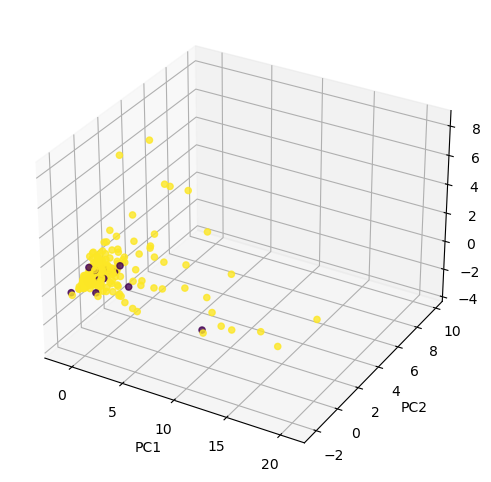

In [51]:
# 図やグラフを図示するためのライブラリをインポートする。
import matplotlib.pyplot as plt

color = []

for i in range(17):
    color.append(0)
for i in range(270):
    color.append(1)

# 第一主成分と第二主成分でプロットする
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': '3d'})
ax.scatter(feature[:, 0], feature[:, 1], feature[:, 2], alpha=0.8, c=color)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()



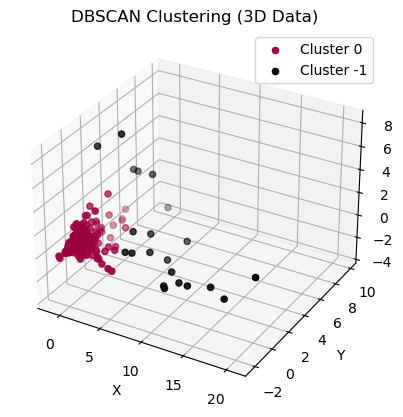

In [52]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

target = feature[:, [0,1,2]]

dbscan = DBSCAN(eps=2.0, min_samples=10)
labels = dbscan.fit_predict(target)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# クラスタごとにプロット
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:  # 外れ値
        color = 'k'  # 黒色
    mask = (labels == label)
    ax.scatter(target[mask, 0], target[mask, 1], target[mask, 2], c=[color], label=f'Cluster {label}')

# グラフの設定
ax.set_title("DBSCAN Clustering (3D Data)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()

In [53]:
detect_price_index = []

for i, value in enumerate(labels):
    if value == -1:
        detect_price_index.append(i)


## 取引量の主成分分析

In [23]:
import sklearn #機械学習のライブラリ
from sklearn.decomposition import PCA #主成分分析器

pca = PCA()
pca.fit(stn_volume_join_feature)
# データを主成分空間に写像
volume_feature = pca.transform(stn_volume_join_feature)

In [24]:
# 主成分得点
pd.DataFrame(volume_feature, columns=["PC{}".format(x + 1) for x in range(len(stn_volume_join_feature.columns))]).head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,-0.835898,-1.915715,0.583885,0.745239,-0.819942,0.252547,0.588913,-0.046549,-0.032147,-0.006297,-7.909485e-16,-9.940184e-18
1,-0.630973,0.309424,0.056501,-0.346906,-0.000642,-0.327992,0.156804,-0.084628,0.010858,-0.026707,-2.560649e-16,-2.903625e-18
2,-1.086000,-0.440834,-0.269823,-0.094948,0.104727,0.047950,-0.004364,0.028335,0.000802,0.009435,-2.699208e-16,2.472633e-17
3,-0.720808,2.154802,-0.300373,0.510316,-0.643737,-2.027557,-0.127894,0.015704,0.016035,-0.009855,7.615385e-17,5.471962e-17
4,-0.422338,0.042328,-0.820482,0.123939,0.348407,-0.353174,0.104776,-0.029295,-0.068918,0.016942,7.147700e-17,-3.398734e-17


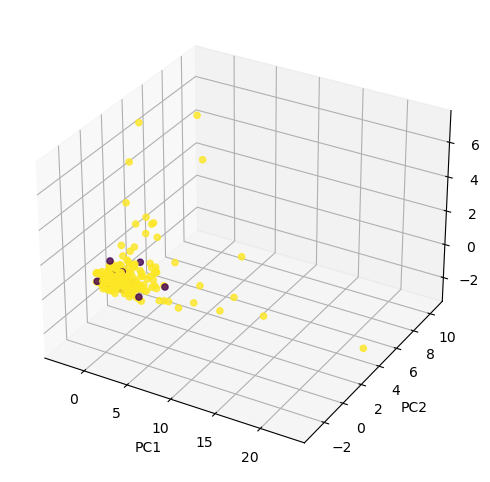

In [27]:
# 図やグラフを図示するためのライブラリをインポートする。
import matplotlib.pyplot as plt

color = []

for i in range(18):
    color.append(0)
for i in range(268):
    color.append(1)

# 第一主成分と第二主成分でプロットする
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': '3d'})
ax.scatter(feature[:, 0], feature[:, 1], feature[:, 2], alpha=0.8, c=color)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()



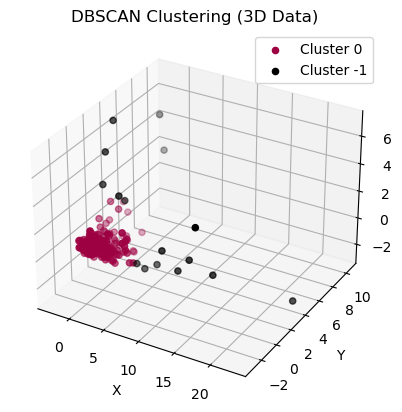

In [42]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

target = volume_feature[:, [0,1,2]]

dbscan = DBSCAN(eps=2.0, min_samples=10)
labels = dbscan.fit_predict(target)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# クラスタごとにプロット
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for i, (label, color) in enumerate(zip(unique_labels, colors)):
    if label == -1:  # 外れ値
        color = 'k'  # 黒色
    mask = (labels == label)
    ax.scatter(target[mask, 0], target[mask, 1], target[mask, 2], c=[color], label=f'Cluster {label}')

# グラフの設定
ax.set_title("DBSCAN Clustering (3D Data)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()

In [46]:
detect_volume_index = []

for i, value in enumerate(labels):
    if value == -1:
        detect_volume_index.append(i)


In [47]:
detect_volume_index

[41, 52, 62, 63, 65, 79, 82, 123, 138, 140, 167, 168, 186, 210, 249, 257]

In [54]:
detect_price_index

[16,
 26,
 38,
 46,
 82,
 89,
 95,
 109,
 127,
 140,
 141,
 153,
 170,
 171,
 179,
 187,
 205,
 218,
 227,
 237,
 285]

In [55]:
ans = set(detect_price_index) & set(detect_volume_index)

In [56]:
ans

{82, 140}